# Clustering analysis with random sampling

We run a set of clustering analyses for different cutoffs and sampling rates. This notebook uses defined inside the `find_clusters.py` file.

## Parameters for clustering analysis

Here we define the overall parameters that will be used for running the analysis. The parameters include a `LABEL` to name the experiments and output data, the path to actually save the output data, sampling rates, cutoffs, as well as any other simulation parameter.

In [1]:
LABEL          = 'random_sampling_analysis'
RESULTS_PATH   = '../results'

SAMPLING_RATES = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
CUTOFFS        = [k*365 for k in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]

SIM_PARAMS = { 'sim_time': 365*30 }
RAND_SEEDS = list( range(0, 100, 5) )

## Initialization

Imports and other environment configuration.

In [2]:
import os
import time
import warnings
import multiprocessing

import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

from find_clusters import run_analysis

In [3]:
# Create output directory and file name prefix
results_dir = os.path.join( os.path.abspath(RESULTS_PATH), LABEL )
if os.path.exists( results_dir ):
    print( '... the directory ', results_dir )
    print( '    already exists. Simulation results may overwrite files in' )
    print( '    this directory.' )
    if input( '    Do you want to continue? [y/N] ' ) != 'y':
        raise Exception('stopping execution')
else:
    os.makedirs( results_dir )

output_prefix = results_dir + '/' + LABEL

## Run simulations

We call the function `run_analysis()` inside `find_clusters.py` to run simulations and save all the results.  We can run several simulations in parallel.

In [4]:
# Let's define the number of parallel processes and a wrapper function with that
# defines the code that a single process will execute
n_processes = max( int(multiprocessing.cpu_count()/2 - 2), 1 )

def analysis_worker( rand_seed ):
    params = SIM_PARAMS
    params['seed'] = rand_seed
    run_analysis( SAMPLING_RATES, CUTOFFS, params, output_prefix )
    return 

In [5]:
# And then run the actual simulations; we use a timeout because some simulations
# may get stuck when the epidemic does't take off
timeout = 1800        # in seconds
tasks   = RAND_SEEDS  # We parallelize based on random seeds
procs   = []          # This keeps track of the processes being executed
t0      = time.time()

with warnings.catch_warnings(): # Avoiding a bunch of error messages
                                # when terminating a process
    warnings.simplefilter('ignore')
    while (len(tasks) > 0) or (len(procs) > 0):
        if (len(tasks) > 0) and (len(procs) < n_processes):  # Launch new processes
            new_seed = tasks.pop(0)
            p = multiprocessing.Process( target=analysis_worker, args=(new_seed,) )
            p.start()
            procs.append( { 'rand_seed':new_seed, 'p':p, 't':time.time()+timeout } )
        
        for d in procs:  # Check if a process finished or timed out
            if not d['p'].is_alive():
                procs.remove(d)
                print( '\n... analysis with rand_seed = ', d['rand_seed'], ' : DONE' )
            elif d['t'] < time.time():
                d['p'].terminate()
                procs.remove(d)
                print( '\n... analysis with rand_seed = ', d['rand_seed'], ' : TIMEOUT' )
        time.sleep(0.05)
    
print( '... time spent running simulations = ', time.time()-t0, ' seconds' )

  |===================                               |  39%
  |===============                                   |  29%
... analysis with rand_seed =  20  : DONE
  |==================================                |  68%
  |===========                                       |  23%
... analysis with rand_seed =  50  : DONE
  |=================================                 |  67%
  |=============================================     |  91%
... analysis with rand_seed =  55  : DONE
  |===================                               |  38%
  |============================================      |  88%
... analysis with rand_seed =  15  : DONE
  |==============                                    |  28%
  |=========================================         |  82%
... analysis with rand_seed =  70  : DONE
  |==================================================| 100%
  |========================================          |  81%
... analysis with rand_seed =  90  : DONE
  |==                       

At this point all the results are in files, not in the notebook. We need to load them into the notebook.

In [6]:
all_results_files = os.listdir(results_dir)
clustering_files = [ k for k in all_results_files if 'cluster_info' in k ]
population_files = {}

cluster_data = pd.DataFrame()
for file in clustering_files:
    data_this_file = pd.read_csv( results_dir + '/' + file )
    cluster_data = pd.concat( [cluster_data, data_this_file], ignore_index=True )

    # Save name of corresponding population files, which will be used for
    # relative risk calculations
    rand_seed = data_this_file.loc[0, 'rand_seed']
    population_files[rand_seed] = file.rstrip('cluster_info.csv') + 'population_summary.csv'

## Results

### Number of clusters and cluster size

In [7]:
# First: some data cleanup
relevant_columns = ['cutoff', 'sampling_rate', 'n_clusters', 'avg_cluster_size']
cluster_data_summary = cluster_data[relevant_columns]

/tmp/ipykernel_354622/2414304768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data_summary['cutoff_in_years'] = cutoff_in_years


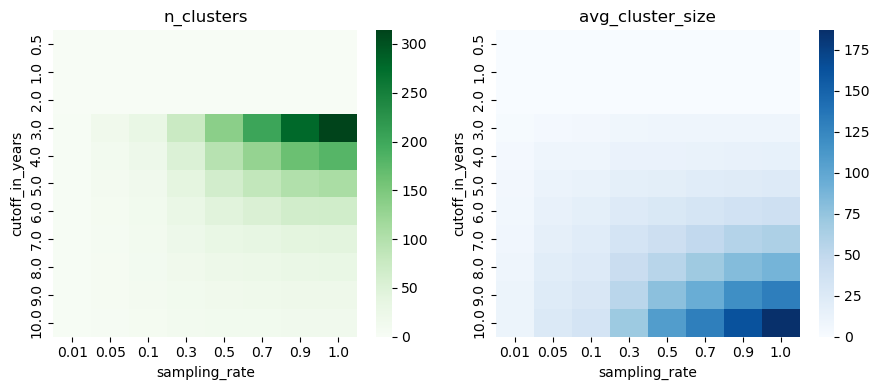

In [8]:
# And now let's draw the plots
cutoff_in_years = cluster_data_summary['cutoff']/365
cluster_data_summary['cutoff_in_years'] = cutoff_in_years
cluster_means = cluster_data_summary.groupby( ['cutoff_in_years', 'sampling_rate'] ).mean()

fig_stats, axs_stats = plt.subplots( 1, 2, figsize=(9, 4) )

seaborn.heatmap( cluster_means['n_clusters'].unstack(), 
                 cmap  = 'Greens', 
                 #annot = True,
                 #fmt   = '.0f',
                 ax    = axs_stats[0]
                )
axs_stats[0].set_title('n_clusters')

seaborn.heatmap( cluster_means['cluster_size_mean'].unstack(), 
                 cmap = 'Blues', 
                 ax   = axs_stats[1] 
                )
axs_stats[1].set_title('cluster_size_mean')

fig_stats.tight_layout()

### Cluster size distributions

In [9]:
# Data preparation and cleanup
cluster_sizes = [ k for k in cluster_data.columns if 'n_clusters_size_' in k ]
relevant_columns = ['cutoff', 'sampling_rate'] + cluster_sizes
cluster_data_distributions = cluster_data[relevant_columns]

# Rename columns and stack
cluster_data_distributions.columns = [ k.lstrip('n_clusters_size_') if 'n_clusters_size_' in k else k for k in cluster_data_distributions.columns  ]
cluster_data_distributions['id'] = range( 0, len(cluster_data_distributions) )
cluster_data_distributions = cluster_data_distributions.groupby(['id', 'cutoff', 'sampling_rate']).mean().stack().reset_index().drop(columns=['id'])
cluster_data_distributions = cluster_data_distributions.rename( {'level_3':'cluster_size',0:'count'}, axis=1 )
cluster_data_distributions['cluster_size'] = cluster_data_distributions['cluster_size'].astype(int)

/tmp/ipykernel_354622/1185196318.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data_distributions['id'] = range( 0, len(cluster_data_distributions) )


... for cutoff =  1095.0 : maximum cluster size of  2697 not shown in the figure.
... for cutoff =  1460.0 : maximum cluster size of  3318 not shown in the figure.
... for cutoff =  1825.0 : maximum cluster size of  3597 not shown in the figure.
... for cutoff =  2190.0 : maximum cluster size of  3768 not shown in the figure.
... for cutoff =  2555.0 : maximum cluster size of  3853 not shown in the figure.
... for cutoff =  2920.0 : maximum cluster size of  3947 not shown in the figure.
... for cutoff =  3285.0 : maximum cluster size of  3990 not shown in the figure.
... for cutoff =  3650.0 : maximum cluster size of  4021 not shown in the figure.


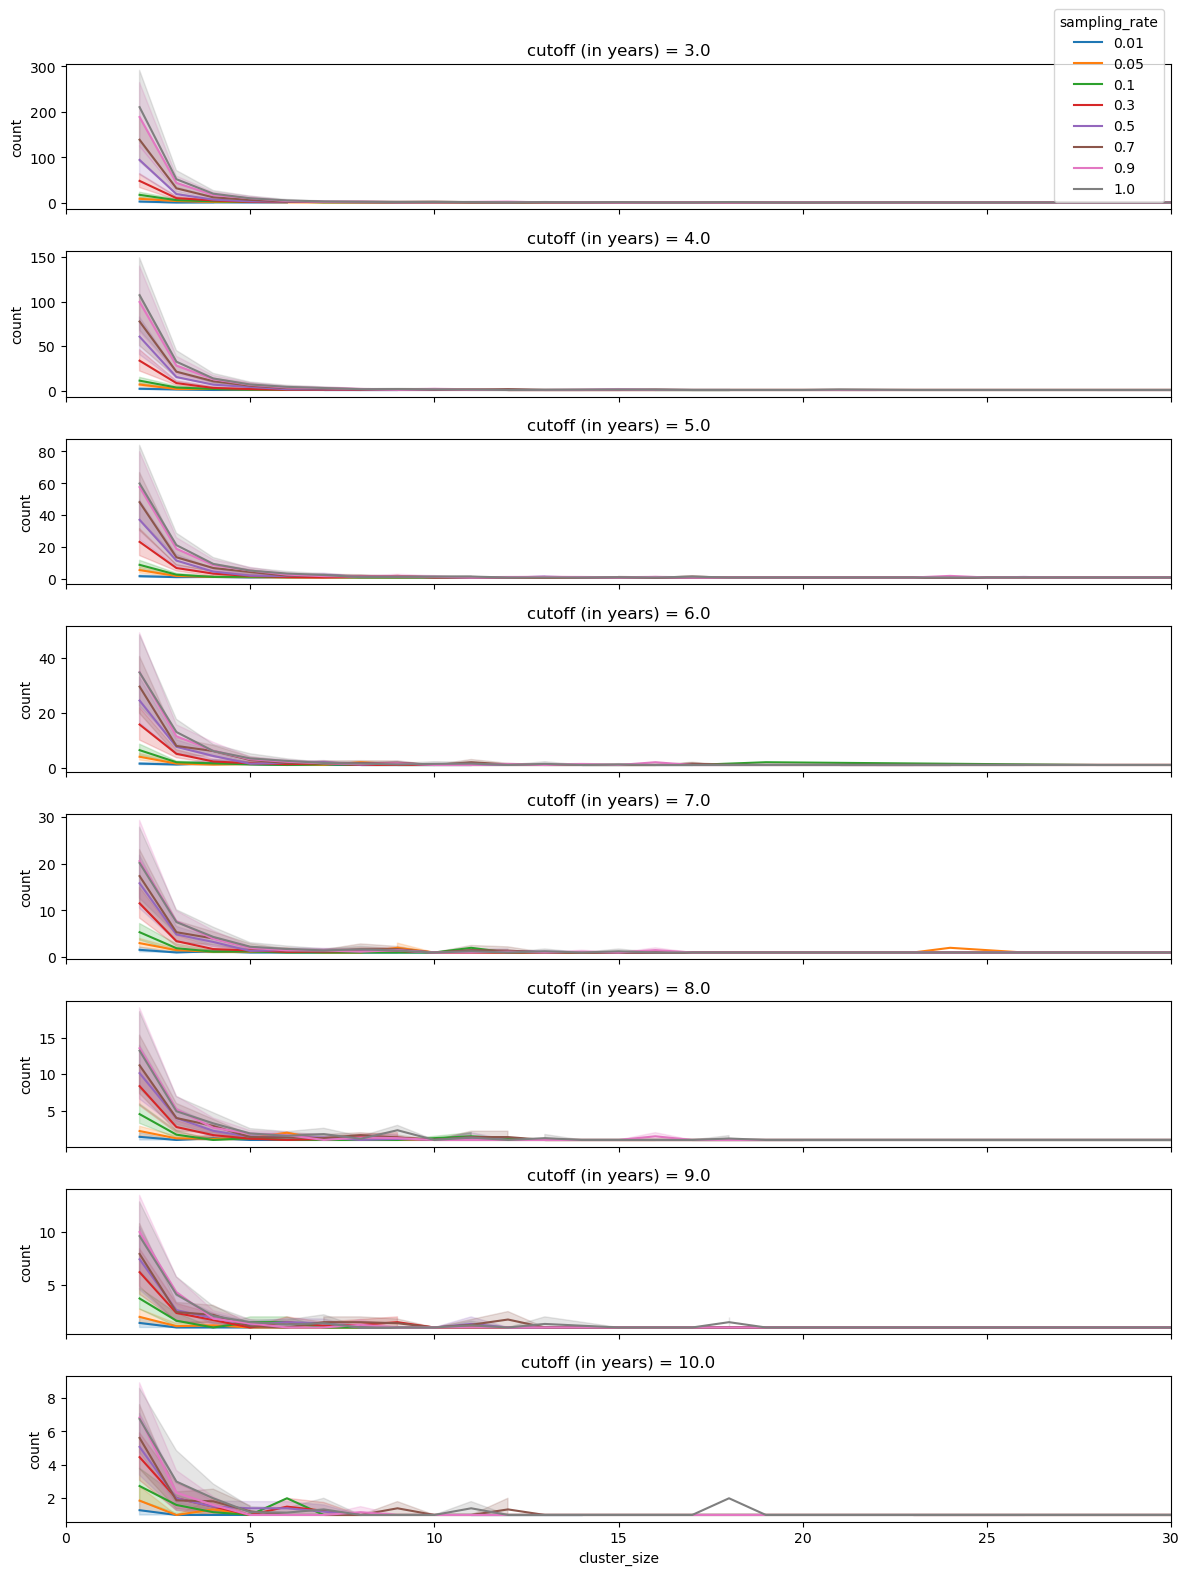

In [10]:
# Cluster size distribution plots
valid_cutoffs = cluster_data_distributions['cutoff'].unique()
n_cutoffs = len( valid_cutoffs )

fig_dist, axs_dist = plt.subplots( n_cutoffs, 1, figsize=(12, 16), sharex=True )

show_legend = True  # only show it in the first subplot
for i, cutoff in enumerate( sorted(valid_cutoffs) ):
    seaborn.lineplot( data    = cluster_data_distributions[ cluster_data_distributions['cutoff']==cutoff ],
                      x       = 'cluster_size',
                      y       = 'count',
                      hue     = 'sampling_rate',
                      palette = 'tab10',
                      legend  = show_legend,
                      ax      = axs_dist[i]
                    )
    axs_dist[i].set_title( 'cutoff (in years) = ' + str(cutoff/365) )
    show_legend = False
    
    max_size = max( cluster_data_distributions[ cluster_data_distributions['cutoff']==cutoff ]['cluster_size'] )
    if max_size > 30:
        axs_dist[i].set_xlim( [0, 30] )
        print( '... for cutoff = ', cutoff, ': maximum cluster size of ', max_size, 'not shown in the figure.' )

fig_dist.tight_layout()

### Characteristics of clustering samples

#### Compute fractions and relative risks

Let's compute some results that will allow us to characterize the role of transmitters in clusters.

In [11]:
cluster_data_rr = pd.DataFrame( columns = [ 'cutoff',
                                            'cutoff_in_years',
                                            'sampling_rate',
                                            'rand_seed',
                                            '% clustered if transmitter',
                                            '% transmitting if clustering',
                                            'RR of being a transmitter if clustering (compared to not clustering)',
                                            'RR of being a transmitter if clustering (compared to all sampled sequences)',
                                            'RR of being a high-transmitter if clustering (compared to not clustering)',
                                            'RR of being a high-transmitter if clustering (compared to all sampled sequences)',
                                           ]
                                    )

for index, row in cluster_data.iterrows():
    
    # Read relevant data
    cutoff        = row['cutoff']
    sampling_rate = row['sampling_rate']
    rand_seed     = row['rand_seed']
    sampled_individuals = np.array( eval( row['sampled_individuals'].replace("'","") ) ).astype(int)
    cluster_labels      = eval( row['cluster_labels'], {'nan':np.nan} )
    
    # Read population file
    population_summary = pd.read_csv( results_dir + '/' + population_files[rand_seed] )
    population_summary_no_seeds = population_summary[ population_summary['source'] != 0 ]

    
    # Get event counts for transmitters
    clustered_ids     = sampled_individuals[ ~np.isnan( cluster_labels ) ]
    not_clustered_ids = sampled_individuals[  np.isnan( cluster_labels ) ]

    all_transmitters  = population_summary_no_seeds['source'].unique()
    non_transmitters  = [ k for k in population_summary['recipient'] if k not in all_transmitters ]

    transmitters_clustering        = [ k for k in clustered_ids     if k     in all_transmitters ]
    transmitters_not_clustering    = [ k for k in not_clustered_ids if k     in all_transmitters ] 
    nontransmitters_clustering     = [ k for k in clustered_ids     if k not in all_transmitters ]
    nontransmitters_not_clustering = [ k for k in not_clustered_ids if k not in all_transmitters ]

    a = len(transmitters_clustering)           # transmitting and clustering
    b = len(transmitters_not_clustering)       # transmitting and non-clustering
    c = len(nontransmitters_clustering)        # non-transmitting and clustering
    d = len(nontransmitters_not_clustering)    # non-transmitting and non-clustering

    
    # Get event counts for high transmitters
    high_transmitters = population_summary_no_seeds[ population_summary_no_seeds['source'].duplicated(keep=False) ]['source'].unique()
    non_hightransmitters  = [ k for k in population_summary['recipient'] if k not in high_transmitters ]
 
    hightransmitters_clustering        = [ k for k in clustered_ids     if k     in high_transmitters ]
    hightransmitters_not_clustering    = [ k for k in not_clustered_ids if k     in high_transmitters ] 
    nonhightransmitters_clustering     = [ k for k in clustered_ids     if k not in high_transmitters ]
    nonhightransmitters_not_clustering = [ k for k in not_clustered_ids if k not in high_transmitters ]
    
    aa = len(hightransmitters_clustering)           # high-transmitting and clustering
    bb = len(hightransmitters_not_clustering)       # high-transmitting and non-clustering
    cc = len(nonhightransmitters_clustering)        # non-hightransmitting and clustering
    dd = len(nonhightransmitters_not_clustering)    # non-hightransmitting and non-clustering
    

    # Compute probabilities
    prob_transmitter_given_clustering    = a / (a+c)   if (a+c)!=0 else np.nan
    prob_transmitter_given_notclustering = b / (b+d)   if (b+d)!=0 else np.nan
    prob_transmitter_given_beingsampled  = (a+b) / (a+b+c+d)  if (a+b+c+d)!=0 else np.nan

    prob_hightransmitter_given_clustering    = aa / (aa+cc)   if (aa+cc)!=0 else np.nan
    prob_hightransmitter_given_notclustering = bb / (bb+dd)   if (bb+dd)!=0 else np.nan
    prob_hightransmitter_given_beingsampled  = (aa+bb) / (aa+bb+cc+dd)  if (aa+bb+cc+dd)!=0 else np.nan

    
    # Compute relative risks
    rr_transmitter_if_clustering__compared_to_non_clustering = prob_transmitter_given_clustering \
                                                               / prob_transmitter_given_notclustering \
                                                                   if prob_transmitter_given_notclustering !=0 else np.nan
    rr_transmitter_if_clustering__compared_to_all_sampled_seq = prob_transmitter_given_clustering \
                                                                / prob_transmitter_given_beingsampled \
                                                                    if prob_transmitter_given_beingsampled !=0 else np.nan
    rr_hightransmitter_if_clustering__compared_to_non_clustering = prob_hightransmitter_given_clustering \
                                                                   / prob_hightransmitter_given_notclustering \
                                                                       if prob_hightransmitter_given_notclustering !=0 else np.nan
    rr_hightransmitter_if_clustering__compared_to_all_sampled_seq = prob_hightransmitter_given_clustering \
                                                                    / prob_hightransmitter_given_beingsampled \
                                                                        if prob_hightransmitter_given_beingsampled !=0 else np.nan

    # Compute fractions
    percent_clustered_if_transmitter   = 100 * len(transmitters_clustering) / len(all_transmitters)
    percent_transmitting_if_clustering = 100 * len(transmitters_clustering) / len(clustered_ids)    if len(clustered_ids)!=0 else np.nan


    # Save results
    results = pd.DataFrame( { 'cutoff'          : [cutoff], 
                              'cutoff_in_years' : [cutoff/365],
                              'sampling_rate'   : [sampling_rate],
                              'rand_seed'       : [rand_seed],
                             
                              '% clustered if transmitter'   : [percent_clustered_if_transmitter],
                              '% transmitting if clustering' : [percent_transmitting_if_clustering],
                             
                              'RR of being a transmitter if clustering (compared to not clustering)'        : [rr_transmitter_if_clustering__compared_to_non_clustering],
                              'RR of being a transmitter if clustering (compared to all sampled sequences)' : [rr_transmitter_if_clustering__compared_to_all_sampled_seq],
                             
                              'RR of being a high-transmitter if clustering (compared to not clustering)'        : [rr_hightransmitter_if_clustering__compared_to_non_clustering],
                              'RR of being a high-transmitter if clustering (compared to all sampled sequences)' : [rr_hightransmitter_if_clustering__compared_to_all_sampled_seq],
                             }
                           )
    cluster_data_rr = pd.concat( [cluster_data_rr, results], ignore_index=True )

# Summarize the results
cluster_data_rr_summary = cluster_data_rr.groupby( ['cutoff_in_years', 'sampling_rate'] ).mean( numeric_only=True )

#### Transmitters and clusters

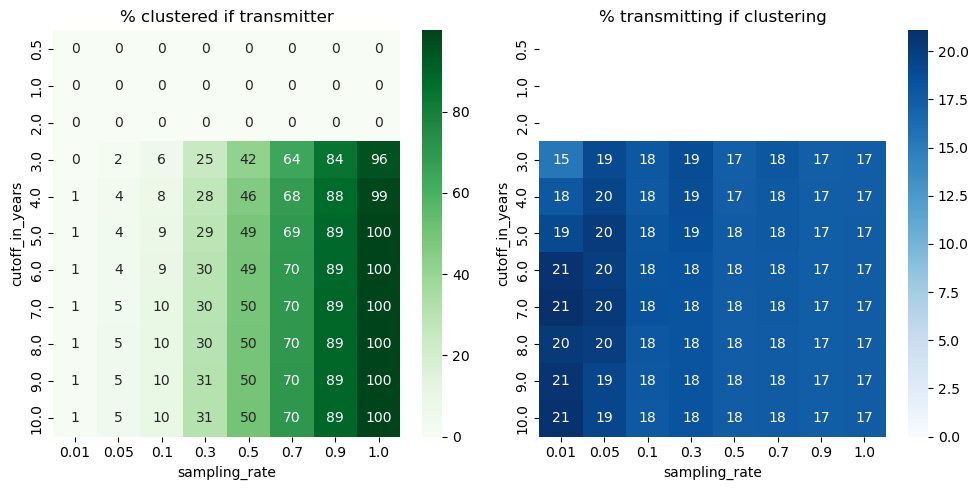

In [12]:
fig_percent, axs_percent = plt.subplots( 1, 2, figsize=(10, 5) )

seaborn.heatmap( cluster_data_rr_summary['% clustered if transmitter'].unstack(), 
                 cmap = 'Greens', 
                 annot = True,
                 fmt   = '.0f',
                 ax   = axs_percent[0] 
                )
axs_percent[0].set_title('% clustered if transmitter')

seaborn.heatmap( cluster_data_rr_summary['% transmitting if clustering'].unstack(), 
                 cmap  = 'Blues',
                 vmin  = 0,
                 annot = True,
                 fmt   = '.0f',
                 ax    = axs_percent[1] 
                )
axs_percent[1].set_title('% transmitting if clustering')

fig_percent.tight_layout()

#### Relative Risk (RR)

Let's see relative risks for transmitters:

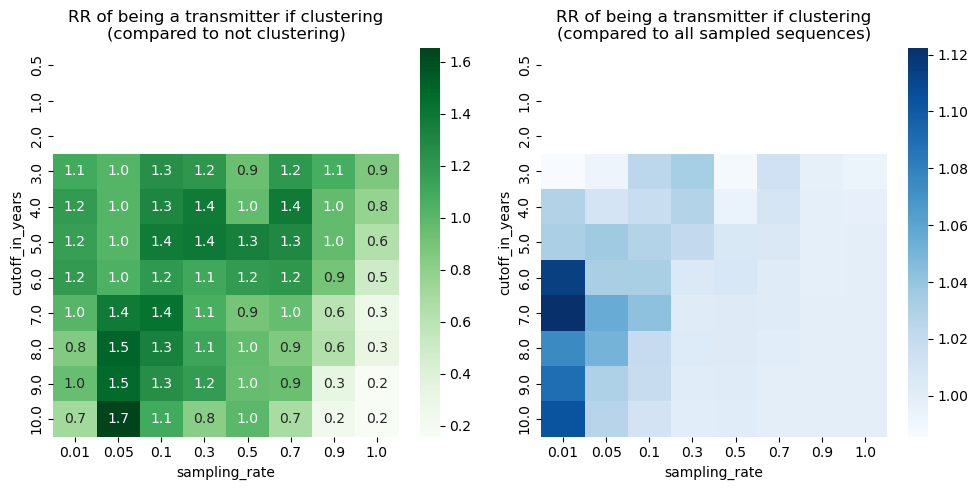

In [13]:
fig_rr_tx, axs_rr_tx = plt.subplots( 1, 2, figsize=(10, 5) )

seaborn.heatmap( cluster_data_rr_summary['RR of being a transmitter if clustering (compared to not clustering)'].unstack(), 
                 cmap = 'Greens', 
                 annot = True,
                 fmt   = '.1f',
                 ax   = axs_rr_tx[0] 
                )
axs_rr_tx[0].set_title('RR of being a transmitter if clustering\n(compared to not clustering)')

seaborn.heatmap( cluster_data_rr_summary['RR of being a transmitter if clustering (compared to all sampled sequences)'].unstack(), 
                 cmap = 'Blues', 
                 ax   = axs_rr_tx[1] 
                )
axs_rr_tx[1].set_title('RR of being a transmitter if clustering\n(compared to all sampled sequences)')

fig_rr_tx.tight_layout()

And now the relative risks for high transmitters (i.e., for any individual with more than one transmission):

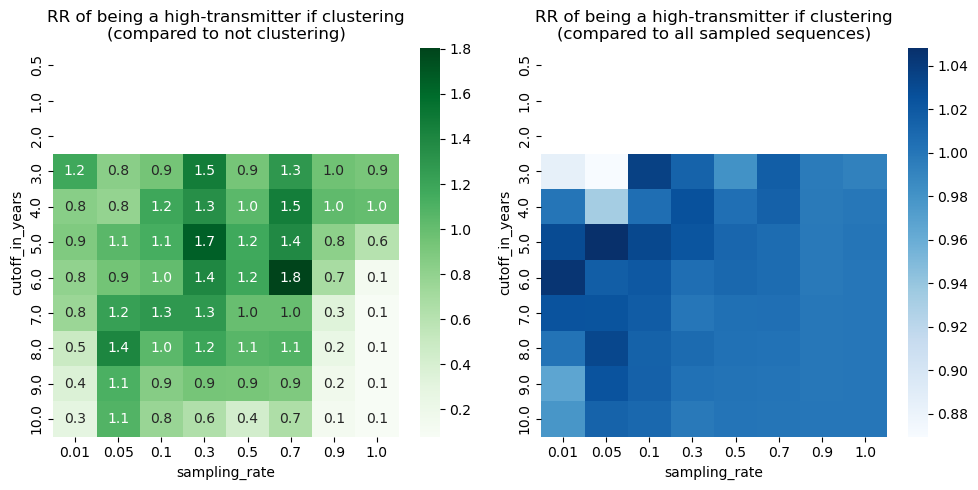

In [14]:
fig_rr_hitx, axs_rr_hitx = plt.subplots( 1, 2, figsize=(10, 5) )

seaborn.heatmap( cluster_data_rr_summary['RR of being a high-transmitter if clustering (compared to not clustering)'].unstack(), 
                 cmap = 'Greens', 
                 annot = True,
                 fmt   = '.1f',
                 ax   = axs_rr_hitx[0] 
                )
axs_rr_hitx[0].set_title('RR of being a high-transmitter if clustering\n(compared to not clustering)')

seaborn.heatmap( cluster_data_rr_summary['RR of being a high-transmitter if clustering (compared to all sampled sequences)'].unstack(), 
                 cmap = 'Blues', 
                 ax   = axs_rr_hitx[1] 
                )
axs_rr_hitx[1].set_title('RR of being a high-transmitter if clustering\n(compared to all sampled sequences)')

fig_rr_hitx.tight_layout()